# Set connection with GitHub

In [1]:
# ! cd /kaggle/working && rm -rf RECsys_Challenge2024

In [2]:
from kaggle_secrets import UserSecretsClient

token = UserSecretsClient().get_secret("Token")

! git clone https://{token}@github.com/madratak/RECsys_Challenge2024.git

Cloning into 'RECsys_Challenge2024'...
remote: Enumerating objects: 7272, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 7272 (delta 43), reused 8 (delta 3), pack-reused 7154 (from 5)
Receiving objects: 100% (7272/7272), 418.97 MiB | 23.45 MiB/s, done.
Resolving deltas: 100% (3924/3924), done.
Updating files: 100% (506/506), done.


In [3]:
! pip install PyGithub requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.9/375.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 28.2 MB/s eta 0:00:00


In [4]:
! pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 61.0 MB/s eta 0:00:00


In [5]:
!pip install timeout-decorator

  Preparing metadata (setup.py) ... done
  Created wheel for timeout-decorator: filename=timeout_decorator-0.5.0-py3-none-any.whl size=5005 sha256=9399c6692d7ab1474fbcf6ecbf29ae20aa15b04d4961093e429c31ecddf39c68
  Stored in directory: /root/.cache/pip/wheels/68/2f/bc/76f1192d474666d41ae6f09813fccbd00fe3f07e8261c4cff5
Successfully built timeout-decorator


In [6]:
%cd /kaggle/working/RECsys_Challenge2024
! python run_compile_all_cython.py

/kaggle/working/RECsys_Challenge2024
run_compile_all_cython: Found 11 Cython files in 5 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/usr/bin/python3'
Compiling [1/11]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorization_Cython_Epoch.c:1252:
/usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wcpp-Wcpp]8;;]
   17 | #warning "Using deprecated NumPy API, disabl

In [7]:
from Utils.notebookFunctions import *
from Utils.xgboost_functions import *
import numpy as np
import pandas as pd
import scipy.sparse as sps
import time
import shutil
import optuna
import json
import os
import gc
from Utils.seconds_to_biggest_unit import seconds_to_biggest_unit
from tqdm import tqdm
from xgboost import XGBRanker

import warnings
import string
from scipy.stats import skew, kurtosis
from numpy import linalg as LA

import timeout_decorator

%matplotlib inline
from xgboost import plot_importance

K_PATH = '/kaggle/working/RECsys_Challenge2024'
GH_PATH = 'TrainedModels/WithoutKFCV'
D_PATH = 'XGBoost'

np.random.seed(42)

In [8]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.MatrixFactorization.FasterIALSRecommender import FasterIALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDItemRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import ScaledPureSVDRecommender
from Recommenders.Neural.MultVAE_PyTorch_Recommender import MultVAERecommender_PyTorch_OptimizerMask 
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python

## Import the repository

In [9]:
repo = get_repo_from_github(token)

Repository 'RECsys_Challenge2024' found.


In [10]:
config = {
    'model': 'XGBoostNoCont',
    'metric': 'MAP',
    'categorical': True,
    'contents': False,
    'tune_parameters': True,
    'database_path': '/kaggle/working/history_XGBoostNoCont_MAP.db',
    'copy_prev_best_params': False,
    'tune_best_params': True,
    'save_github': True
}

Import the database where previous tuning trials have been saved.

In [11]:
try:
    shutil.copyfile(
        f'{K_PATH}/{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/history_{config["model"]}_{config["metric"]}.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass # if not present optuna will create it

Save the best trial value saved in the imported db from optuna.

In [12]:
optuna_study = optuna.load_study(study_name=f'hyperparameters_tuning_{config["model"]}_{config["metric"]}',
                                storage=f'sqlite:///{config["database_path"]}')

# Access the best trial
best_saved_value = optuna_study.best_trial.value

print("Best value:", best_saved_value)

Best value: 0.062178943225928276


# Construction of URM and ICM matrices

In [13]:
URM_all_dataframe = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_train.csv")

n_users = len(URM_all_dataframe["user_id"].unique())
n_items = len(URM_all_dataframe["item_id"].unique())

URM_all = sps.csr_matrix((URM_all_dataframe["data"].values, 
                          (URM_all_dataframe["user_id"].values, URM_all_dataframe["item_id"].values)),
                        shape = (n_users, n_items))

URM_all

<35736x38121 sparse matrix of type '<class 'numpy.float64'>'
	with 1764607 stored elements in Compressed Sparse Row format>

In [14]:
ICM_dataframe = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_ICM_metadata.csv")

n_items = len(ICM_dataframe["item_id"].unique())
n_features = len(ICM_dataframe["feature_id"].unique())

ICM_all = sps.csr_matrix((ICM_dataframe["data"].values, 
                          (ICM_dataframe["item_id"].values, ICM_dataframe["feature_id"].values)),
                        shape = (n_items, n_features))

ICM_all

<38121x94331 sparse matrix of type '<class 'numpy.float64'>'
	with 2940040 stored elements in Compressed Sparse Row format>

## Import dataframes

In [15]:
dataframes_path = f'/kaggle/input/dataframes-{config["model"].lower()}'

if os.path.exists(dataframes_path):
    print("Dataframe directory is ready to be used.")
else:
    print("No dataframes directory is present.")

Dataframe directory is ready to be used.


# Training
Split the dataset in train, validation and test set.

In [16]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 141 ( 0.4%) Users that have less than 1 test interactions


Function to fit the hybrid recommender that is going to be used as candidate generator.

## Candidate Generators

Select the best previously trained recommenders to use inside the hybrid recommender (candidate generator).

In [17]:
cg_recommenders = {
    "ItemKNNCF": ItemKNNCFRecommender,
    "SLIMElasticNet": SLIMElasticNetRecommender,
    "RP3beta": RP3betaRecommender,
}

## Features
Select the other previously trained recommenders to use them as features.

In [18]:
f_recommenders = {
    "RP3beta": RP3betaRecommender,
    "P3alpha": P3alphaRecommender,
    "ItemKNNCF": ItemKNNCFRecommender,
    "ItemKNNCBF": ItemKNNCBFRecommender,
    "UserKNNCF": UserKNNCFRecommender,
    "FasterIALS": FasterIALSRecommender,
    "NMF": NMFRecommender,
    "PureSVDItem": PureSVDItemRecommender,
    "ScaledPureSVD": ScaledPureSVDRecommender,
    "MultVAE": MultVAERecommender_PyTorch_OptimizerMask,
    "SLIMElasticNet": SLIMElasticNetRecommender,
    "SLIM_BPR": SLIM_BPR_Python,
}

## Training dataframe building
Build the dataframe with the predictions, the popularity of the item, the user activity, the profile length, item features and others.

Then, set features and target to use for the training.

In [19]:
if config["tune_parameters"]:
    
    if os.path.exists(dataframes_path + f'/training_dataframe_{config["model"]}.parquet'):
        training_dataframe = pd.read_parquet(dataframes_path + f'/training_dataframe_{config["model"]}.parquet')
        groups_train = training_dataframe.groupby("UserID").size().values
        print("training_dataframe and groups_train loaded.")
    
    else:
        print("***TRAINING CONTENT GENERATION RECOMMENDERS***\n")
        candidate_generator_recommenders = fit_recommenders("Recall", "Train", URM_train, ICM_all, cg_recommenders, GH_PATH, "cg", repo)
    
        print("***TRAINING FEATURE RECOMMENDERS***\n")
        features_recommenders = fit_recommenders("MAP", "Train", URM_train, ICM_all, f_recommenders, GH_PATH, "f", repo)

        print()
        training_dataframe, groups_train = create_XGBoost_dataframe(URM_train, candidate_generator_recommenders, features_recommenders, ICM_all, URM_validation, cutoff=50, categorical=config["categorical"], contents=config["contents"])
        training_dataframe.to_parquet(f'/kaggle/working/training_dataframe_{config["model"]}.parquet')

        del candidate_generator_recommenders, features_recommenders
        
    display(training_dataframe)

    y_train = training_dataframe["Label"]
    X_train = training_dataframe.drop(columns=["Label"])

    del training_dataframe

training_dataframe and groups_train loaded.


,UserID,ItemID,Label,feature_recommender_count,RP3beta_score,RP3beta_position,P3alpha_score,P3alpha_position,ItemKNNCF_score,ItemKNNCF_position,...,SLIM_BPR_position,Mean_Position,Std_Position,Min_Position,Max_Position,Median_Position,Skew_Position,Kurtosis_Position,item_popularity,user_profile_len
0,0,399.0,False,7,0.643288,6.0,0.469522,24.0,0.514353,9.0,...,1.0,19.500000,24.130328,1.0,71.0,7.5,1.151161,-0.043285,0.146779,0.017751
1,0,13736.0,False,0,0.268304,43.0,0.341841,39.0,0.000000,51.0,...,53.0,36.916667,17.238742,11.0,59.0,41.0,-0.342628,-1.406343,0.060190,0.017751
2,0,11966.0,False,2,0.000000,73.0,0.000000,77.0,0.000000,46.0,...,52.0,39.500000,27.268030,7.0,87.0,28.5,0.540626,-1.068238,0.031679,0.017751
3,0,11919.0,False,3,0.532764,11.0,0.640380,8.0,0.774916,3.0,...,24.0,24.333333,15.933574,3.0,57.0,25.5,0.462244,-0.545135,0.022175,0.017751
4,0,11548.0,False,0,0.491637,13.0,0.000000,68.0,0.480740,11.0,...,39.0,38.750000,23.848480,11.0,81.0,36.5,0.332176,-1.110081,0.026399,0.017751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945959,35735,35750.0,False,0,0.131501,41.0,0.131075,36.0,0.146385,44.0,...,19.0,45.583333,12.623631,19.0,61.0,46.0,-0.590622,-0.351705,0.013728,0.006455
2945960,35735,35753.0,False,6,0.685558,2.0,0.682698,4.0,0.703247,5.0,...,16.0,16.166667,16.557521,2.0,61.0,10.5,1.734254,2.522402,0.016895,0.006455
2945961,35735,36034.0,False,11,0.999998,1.0,0.999998,1.0,0.937448,2.0,...,1.0,2.333333,2.870962,1.0,11.0,1.0,2.563566,5.279196,0.055966,0.006455
2945962,35735,34997.0,False,1,0.000000,59.0,0.000000,55.0,0.000000,63.0,...,56.0,47.000000,16.303931,9.0,64.0,49.5,-1.075036,0.447158,0.078141,0.006455


## Validation and Testing dataframe building

The first dataset excludes the label column since it is used to evaluate the performance of the model with the hyperparameters chosen by Optuna. In contrast, the second dataset includes the label column and is used to train the final model selected by Optuna.

In [20]:
if config["tune_parameters"] or config["tune_best_params"]:
    
    if os.path.exists(dataframes_path + f'/testing_dataframe_{config["model"]}.parquet' ):
        testing_dataframe = pd.read_parquet(dataframes_path + f'/testing_dataframe_{config["model"]}.parquet')
        groups_test = testing_dataframe.groupby("UserID").size().values
        print("testing_dataframe and groups_test loaded.")
    
    else:

        print("***TRAINING CONTENT GENERATION RECOMMENDERS***\n")
        candidate_generator_recommenders = fit_recommenders("Recall", "TrainVal", URM_train + URM_validation, ICM_all, cg_recommenders, GH_PATH, "cg", repo)

        print("***TRAINING FEATURE RECOMMENDERS***\n")
        features_recommenders = fit_recommenders("MAP", "TrainVal", URM_train + URM_validation, ICM_all, f_recommenders, GH_PATH, "f", repo)

        print()
        testing_dataframe, groups_test = create_XGBoost_dataframe(URM_train + URM_validation, candidate_generator_recommenders, features_recommenders, ICM_all, URM_test, cutoff=50, categorical=config["categorical"], contents=config["contents"])
        testing_dataframe.to_parquet(f'/kaggle/working/testing_dataframe_{config["model"]}.parquet')

        del candidate_generator_recommenders, features_recommenders

    if config["tune_parameters"]:
        validation_dataframe = testing_dataframe.drop(columns=["Label"])
        display(validation_dataframe)

testing_dataframe and groups_test loaded.


,UserID,ItemID,feature_recommender_count,RP3beta_score,RP3beta_position,P3alpha_score,P3alpha_position,ItemKNNCF_score,ItemKNNCF_position,ItemKNNCBF_score,...,SLIM_BPR_position,Mean_Position,Std_Position,Min_Position,Max_Position,Median_Position,Skew_Position,Kurtosis_Position,item_popularity,user_profile_len
0,0,51.0,2,0.774121,6.0,0.788552,4.0,0.286975,41.0,0.000000,...,38.0,51.833333,33.141112,4.0,89.0,47.5,-0.193114,-1.452967,0.109336,0.020373
1,0,11966.0,7,0.727009,9.0,0.704616,6.0,0.896390,3.0,0.000000,...,23.0,16.916667,15.506353,3.0,51.0,9.5,1.285972,0.255258,0.032801,0.020373
2,0,11875.0,0,0.226606,71.0,0.199602,64.0,0.234023,49.0,0.000000,...,22.0,50.333333,22.166040,22.0,92.0,46.5,0.406129,-0.797269,0.021026,0.020373
3,0,9911.0,2,0.192488,77.0,0.168287,71.0,0.411140,32.0,0.000000,...,32.0,45.000000,27.349589,4.0,84.0,40.5,0.001365,-1.334524,0.016821,0.020373
4,0,9316.0,0,0.254083,61.0,0.251083,47.0,0.000000,92.0,0.000000,...,93.0,66.000000,22.506565,31.0,95.0,64.0,-0.037929,-1.435534,0.025231,0.020373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2878785,35735,35713.0,0,0.356445,18.0,0.132292,34.0,0.076987,53.0,0.000000,...,35.0,37.416667,12.929588,18.0,66.0,34.5,0.750278,0.206371,0.026072,0.005576
2878786,35735,35712.0,0,0.124700,44.0,0.112612,42.0,0.200205,27.0,0.232427,...,15.0,28.416667,9.995075,12.0,44.0,27.5,-0.012696,-0.893587,0.017662,0.005576
2878787,35735,35660.0,1,0.240297,31.0,0.126944,37.0,0.178835,31.0,0.000000,...,34.0,32.416667,11.858701,10.0,57.0,31.0,0.271387,0.283409,0.019344,0.005576
2878788,35735,36032.0,0,0.000000,61.0,0.000000,59.0,0.000000,62.0,0.000000,...,59.0,58.250000,9.016399,36.0,67.0,61.0,-1.634772,1.437730,0.013457,0.005576


## XGBoost training
Let's train XGBoost to rerank those prediction using as lable whether they should be recommended or not.

In [21]:
from Recommenders.XGBoost.XGBoostRankerRecommender import XGBoostRankerRecommender
from timeout_decorator.timeout_decorator import TimeoutError

@timeout_decorator.timeout(3600*2, timeout_exception=optuna.TrialPruned, use_signals=False)
def objective_function_XGBoostRanker(optuna_trial):
    
    recommender_instance = XGBoostRankerRecommender(URM_train + URM_validation, X_train, y_train, validation_dataframe)

    full_hyperp = {
            "n_estimators": optuna_trial.suggest_int("n_estimators", 50, 500),
            "learning_rate": optuna_trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
            "reg_alpha": optuna_trial.suggest_float("reg_alpha", 1e-4, 1.0, log=True),
            "reg_lambda": optuna_trial.suggest_float("reg_lambda", 1e-4, 1.0, log=True),
            "max_depth": optuna_trial.suggest_int("max_depth", 3, 7),
            "max_leaves": optuna_trial.suggest_int("max_leaves", 2, 128),
            "grow_policy": optuna_trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            "booster": optuna_trial.suggest_categorical("booster", ["gbtree", "dart"]),
            # "tree_method": optuna_trial.suggest_categorical("tree_method", ["hist", "gpu_hist", "approx"]),
            "tree_method": "hist",
            "objective": optuna_trial.suggest_categorical("objective", ["map", "pairwise", "ndcg"])
        }

    recommender_instance.fit(
        groups_train,
        **full_hyperp
    )

    result_df, _ = evaluator_test.evaluateRecommender(recommender_instance)
    
    return result_df.loc[10]["MAP"]

In [22]:
if config['tune_parameters']:
    
    optuna_study = optuna.create_study(direction='maximize', study_name=f'hyperparameters_tuning_{config["model"]}_{config["metric"]}',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)

    optuna_study.optimize(objective_function_XGBoostRanker, timeout=3600 * 9)

[I 2025-01-07 01:07:23,065] Using an existing study with name 'hyperparameters_tuning_XGBoostNoCont_MAP' instead of creating a new one.


EvaluatorHoldout: Processed 28000 (78.7%) in 5.04 min. Users per second: 93
EvaluatorHoldout: Processed 35595 (100.0%) in 6.40 min. Users per second: 93


[I 2025-01-07 01:18:08,432] Trial 30 finished with value: 0.060479070094112415 and parameters: {'n_estimators': 462, 'learning_rate': 0.0001348112754031178, 'reg_alpha': 0.00457971697533564, 'reg_lambda': 0.0009815873276697148, 'max_depth': 4, 'max_leaves': 82, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 7 with value: 0.062178943225928276.


EvaluatorHoldout: Processed 29000 (81.5%) in 5.09 min. Users per second: 95
EvaluatorHoldout: Processed 35595 (100.0%) in 6.23 min. Users per second: 95


[I 2025-01-07 01:26:08,475] Trial 31 finished with value: 0.06199647266313766 and parameters: {'n_estimators': 185, 'learning_rate': 0.04985439166049385, 'reg_alpha': 0.008043320090047459, 'reg_lambda': 0.15619022416844427, 'max_depth': 5, 'max_leaves': 108, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'pairwise'}. Best is trial 7 with value: 0.062178943225928276.


EvaluatorHoldout: Processed 29000 (81.5%) in 5.00 min. Users per second: 97
EvaluatorHoldout: Processed 35595 (100.0%) in 6.12 min. Users per second: 97


[I 2025-01-07 01:32:54,816] Trial 32 finished with value: 0.06172053993672023 and parameters: {'n_estimators': 54, 'learning_rate': 0.08036128957454335, 'reg_alpha': 0.0008952977644730304, 'reg_lambda': 0.1993705767062605, 'max_depth': 5, 'max_leaves': 116, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'pairwise'}. Best is trial 7 with value: 0.062178943225928276.


EvaluatorHoldout: Processed 29000 (81.5%) in 5.11 min. Users per second: 95
EvaluatorHoldout: Processed 35595 (100.0%) in 6.27 min. Users per second: 95


[I 2025-01-07 01:40:50,065] Trial 33 finished with value: 0.062014075902401156 and parameters: {'n_estimators': 174, 'learning_rate': 0.17041930109269096, 'reg_alpha': 0.0020101610751262562, 'reg_lambda': 0.5289564096771704, 'max_depth': 6, 'max_leaves': 119, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'pairwise'}. Best is trial 7 with value: 0.062178943225928276.


EvaluatorHoldout: Processed 28000 (78.7%) in 5.02 min. Users per second: 93
EvaluatorHoldout: Processed 35595 (100.0%) in 6.36 min. Users per second: 93


[I 2025-01-07 01:49:24,418] Trial 34 finished with value: 0.062019180730304255 and parameters: {'n_estimators': 240, 'learning_rate': 0.041437884894771564, 'reg_alpha': 0.03766012319299838, 'reg_lambda': 0.2007826113228756, 'max_depth': 5, 'max_leaves': 111, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'pairwise'}. Best is trial 7 with value: 0.062178943225928276.


EvaluatorHoldout: Processed 28000 (78.7%) in 5.11 min. Users per second: 91
EvaluatorHoldout: Processed 35595 (100.0%) in 6.48 min. Users per second: 92


[I 2025-01-07 01:58:26,607] Trial 35 finished with value: 0.059704815193856606 and parameters: {'n_estimators': 284, 'learning_rate': 0.29550018017808166, 'reg_alpha': 0.002621045587582707, 'reg_lambda': 0.06149529375475351, 'max_depth': 6, 'max_leaves': 58, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'ndcg'}. Best is trial 7 with value: 0.062178943225928276.
[I 2025-01-07 03:58:26,709] Trial 36 pruned. 


EvaluatorHoldout: Processed 26000 (73.0%) in 5.03 min. Users per second: 86
EvaluatorHoldout: Processed 35595 (100.0%) in 6.87 min. Users per second: 86


[I 2025-01-07 04:10:16,620] Trial 37 finished with value: 0.061820878400522625 and parameters: {'n_estimators': 436, 'learning_rate': 0.008442619706756709, 'reg_alpha': 0.003238568519665574, 'reg_lambda': 0.0028428625257136872, 'max_depth': 6, 'max_leaves': 89, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'ndcg'}. Best is trial 7 with value: 0.062178943225928276.
[I 2025-01-07 06:10:16,718] Trial 38 pruned. 


EvaluatorHoldout: Processed 28000 (78.7%) in 5.12 min. Users per second: 91
EvaluatorHoldout: Processed 35595 (100.0%) in 6.49 min. Users per second: 91


[I 2025-01-07 06:18:24,451] Trial 39 finished with value: 0.061339719106257254 and parameters: {'n_estimators': 141, 'learning_rate': 0.013852805917547919, 'reg_alpha': 0.0004900893711513976, 'reg_lambda': 0.571546427768548, 'max_depth': 5, 'max_leaves': 80, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'ndcg'}. Best is trial 7 with value: 0.062178943225928276.


EvaluatorHoldout: Processed 27000 (75.9%) in 5.12 min. Users per second: 88
EvaluatorHoldout: Processed 35595 (100.0%) in 6.74 min. Users per second: 88


[I 2025-01-07 06:27:55,652] Trial 40 finished with value: 0.06170421206830647 and parameters: {'n_estimators': 266, 'learning_rate': 0.07958409230744555, 'reg_alpha': 0.015505873689425477, 'reg_lambda': 0.03847214188719766, 'max_depth': 7, 'max_leaves': 67, 'grow_policy': 'depthwise', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 7 with value: 0.062178943225928276.


EvaluatorHoldout: Processed 27000 (75.9%) in 5.17 min. Users per second: 87
EvaluatorHoldout: Processed 35595 (100.0%) in 6.80 min. Users per second: 87


[I 2025-01-07 06:38:52,879] Trial 41 finished with value: 0.062082485501573186 and parameters: {'n_estimators': 494, 'learning_rate': 0.08024459668053201, 'reg_alpha': 0.030450444879063922, 'reg_lambda': 0.056268676239820146, 'max_depth': 4, 'max_leaves': 70, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 7 with value: 0.062178943225928276.


EvaluatorHoldout: Processed 27000 (75.9%) in 5.08 min. Users per second: 89
EvaluatorHoldout: Processed 35595 (100.0%) in 6.69 min. Users per second: 89


[I 2025-01-07 06:49:46,285] Trial 42 finished with value: 0.06217369792885805 and parameters: {'n_estimators': 476, 'learning_rate': 0.037210013350591334, 'reg_alpha': 0.13604777024425085, 'reg_lambda': 0.15635282579945087, 'max_depth': 4, 'max_leaves': 50, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 7 with value: 0.062178943225928276.


EvaluatorHoldout: Processed 27000 (75.9%) in 5.02 min. Users per second: 90
EvaluatorHoldout: Processed 35595 (100.0%) in 6.62 min. Users per second: 90


[I 2025-01-07 07:00:20,083] Trial 43 finished with value: 0.061773290568274124 and parameters: {'n_estimators': 468, 'learning_rate': 0.02054669449275186, 'reg_alpha': 0.6710134115624142, 'reg_lambda': 0.15002993407400542, 'max_depth': 3, 'max_leaves': 56, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 7 with value: 0.062178943225928276.


EvaluatorHoldout: Processed 27000 (75.9%) in 5.15 min. Users per second: 87
EvaluatorHoldout: Processed 35595 (100.0%) in 6.76 min. Users per second: 88


[I 2025-01-07 07:11:18,511] Trial 44 finished with value: 0.06217274586005932 and parameters: {'n_estimators': 474, 'learning_rate': 0.036423499975149654, 'reg_alpha': 0.35390991426076257, 'reg_lambda': 0.2296412052484583, 'max_depth': 4, 'max_leaves': 42, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 7 with value: 0.062178943225928276.


EvaluatorHoldout: Processed 27000 (75.9%) in 5.10 min. Users per second: 88
EvaluatorHoldout: Processed 35595 (100.0%) in 6.71 min. Users per second: 88


[I 2025-01-07 07:21:50,333] Trial 45 finished with value: 0.0621845396959156 and parameters: {'n_estimators': 425, 'learning_rate': 0.03501522558105315, 'reg_alpha': 0.3022280035374722, 'reg_lambda': 0.23644808131526268, 'max_depth': 4, 'max_leaves': 42, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 45 with value: 0.0621845396959156.


EvaluatorHoldout: Processed 27000 (75.9%) in 5.04 min. Users per second: 89
EvaluatorHoldout: Processed 35595 (100.0%) in 6.64 min. Users per second: 89


[I 2025-01-07 07:32:19,959] Trial 46 finished with value: 0.06215569334911713 and parameters: {'n_estimators': 428, 'learning_rate': 0.03673268847867624, 'reg_alpha': 0.3322040691509825, 'reg_lambda': 0.5857697446984669, 'max_depth': 4, 'max_leaves': 43, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 45 with value: 0.0621845396959156.
[I 2025-01-07 09:32:20,048] Trial 47 pruned. 


EvaluatorHoldout: Processed 27000 (75.9%) in 5.09 min. Users per second: 88
EvaluatorHoldout: Processed 35595 (100.0%) in 6.71 min. Users per second: 88


[I 2025-01-07 09:42:26,797] Trial 48 finished with value: 0.061237264686272344 and parameters: {'n_estimators': 354, 'learning_rate': 0.004928390234684589, 'reg_alpha': 0.37749770623231127, 'reg_lambda': 0.33745104318815394, 'max_depth': 4, 'max_leaves': 23, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 45 with value: 0.0621845396959156.


EvaluatorHoldout: Processed 27000 (75.9%) in 5.09 min. Users per second: 88
EvaluatorHoldout: Processed 35595 (100.0%) in 6.70 min. Users per second: 89


[I 2025-01-07 09:52:39,297] Trial 49 finished with value: 0.06214403329342041 and parameters: {'n_estimators': 381, 'learning_rate': 0.03576634006947308, 'reg_alpha': 0.15108686721460002, 'reg_lambda': 0.2362663368791936, 'max_depth': 4, 'max_leaves': 47, 'grow_policy': 'depthwise', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 45 with value: 0.0621845396959156.


EvaluatorHoldout: Processed 28000 (78.7%) in 5.14 min. Users per second: 91
EvaluatorHoldout: Processed 35595 (100.0%) in 6.54 min. Users per second: 91


[I 2025-01-07 10:02:45,845] Trial 50 finished with value: 0.06152301130219188 and parameters: {'n_estimators': 420, 'learning_rate': 0.017593585981785606, 'reg_alpha': 0.8738136799082656, 'reg_lambda': 0.5747635476322163, 'max_depth': 3, 'max_leaves': 33, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 45 with value: 0.0621845396959156.


EvaluatorHoldout: Processed 27000 (75.9%) in 5.10 min. Users per second: 88
EvaluatorHoldout: Processed 35595 (100.0%) in 6.70 min. Users per second: 89


[I 2025-01-07 10:13:46,119] Trial 51 finished with value: 0.06213827851691118 and parameters: {'n_estimators': 474, 'learning_rate': 0.026314780180436675, 'reg_alpha': 0.2969099375245993, 'reg_lambda': 0.26381794802993785, 'max_depth': 4, 'max_leaves': 42, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 45 with value: 0.0621845396959156.


Check whether a better value was found in the new tuning performed to avoid repetitive tuning.

In [23]:
if config["tune_parameters"] and optuna_study.best_trial.value <= best_saved_value:
    config["tune_best_params"] = False

### Some optuna visualizations on recommender parameters

In [24]:
if not config['tune_parameters']:
    optuna_study = optuna.load_study(study_name=f'hyperparameters_tuning_{config["model"]}_{config["metric"]}', storage=f'sqlite:///{config["database_path"]}')
    
fig = optuna.visualization.plot_slice(optuna_study)
fig.show()

In [25]:
if not config['tune_parameters']:
    optuna_study = optuna.load_study(study_name=f'hyperparameters_tuning_{config["model"]}_{config["metric"]}', storage=f'sqlite:///{config["database_path"]}')
    
fig = optuna.visualization.plot_param_importances(optuna_study)
fig.show()

# Testing
## Prediction dataframe building

In [26]:
if config["tune_best_params"]:
    display(testing_dataframe)

,UserID,ItemID,Label,feature_recommender_count,RP3beta_score,RP3beta_position,P3alpha_score,P3alpha_position,ItemKNNCF_score,ItemKNNCF_position,...,SLIM_BPR_position,Mean_Position,Std_Position,Min_Position,Max_Position,Median_Position,Skew_Position,Kurtosis_Position,item_popularity,user_profile_len
0,0,51.0,False,2,0.774121,6.0,0.788552,4.0,0.286975,41.0,...,38.0,51.833333,33.141112,4.0,89.0,47.5,-0.193114,-1.452967,0.109336,0.020373
1,0,11966.0,False,7,0.727009,9.0,0.704616,6.0,0.896390,3.0,...,23.0,16.916667,15.506353,3.0,51.0,9.5,1.285972,0.255258,0.032801,0.020373
2,0,11875.0,False,0,0.226606,71.0,0.199602,64.0,0.234023,49.0,...,22.0,50.333333,22.166040,22.0,92.0,46.5,0.406129,-0.797269,0.021026,0.020373
3,0,9911.0,False,2,0.192488,77.0,0.168287,71.0,0.411140,32.0,...,32.0,45.000000,27.349589,4.0,84.0,40.5,0.001365,-1.334524,0.016821,0.020373
4,0,9316.0,False,0,0.254083,61.0,0.251083,47.0,0.000000,92.0,...,93.0,66.000000,22.506565,31.0,95.0,64.0,-0.037929,-1.435534,0.025231,0.020373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2878785,35735,35713.0,False,0,0.356445,18.0,0.132292,34.0,0.076987,53.0,...,35.0,37.416667,12.929588,18.0,66.0,34.5,0.750278,0.206371,0.026072,0.005576
2878786,35735,35712.0,False,0,0.124700,44.0,0.112612,42.0,0.200205,27.0,...,15.0,28.416667,9.995075,12.0,44.0,27.5,-0.012696,-0.893587,0.017662,0.005576
2878787,35735,35660.0,False,1,0.240297,31.0,0.126944,37.0,0.178835,31.0,...,34.0,32.416667,11.858701,10.0,57.0,31.0,0.271387,0.283409,0.019344,0.005576
2878788,35735,36032.0,False,0,0.000000,61.0,0.000000,59.0,0.000000,62.0,...,59.0,58.250000,9.016399,36.0,67.0,61.0,-1.634772,1.437730,0.013457,0.005576


In [27]:
if config["tune_best_params"]:
    
    if os.path.exists(dataframes_path + f'/prediction_dataframe_{config["model"]}.parquet'):
        prediction_dataframe = pd.read_parquet(dataframes_path + f'/prediction_dataframe_{config["model"]}.parquet')
        print("prediction_dataframe loaded.")
    
    else:

        print("***TRAINING CONTENT GENERATION RECOMMENDERS***\n")
        candidate_generator_recommenders = fit_recommenders("Recall", "TrainValTest", URM_all, ICM_all, cg_recommenders, GH_PATH, "cg", repo)

        print("***TRAINING FEATURE RECOMMENDERS***\n")
        features_recommenders = fit_recommenders("MAP", "TrainValTest", URM_all, ICM_all, f_recommenders, GH_PATH, "f", repo)

        print()
        prediction_dataframe = create_XGBoost_dataframe(URM_all, candidate_generator_recommenders, features_recommenders, ICM_all, cutoff=50, categorical=config["categorical"], contents=config["contents"])
        prediction_dataframe.to_parquet(f'/kaggle/working/prediction_dataframe_{config["model"]}.parquet')

        del candidate_generator_recommenders, features_recommenders
    
    display(prediction_dataframe)

    y_test = testing_dataframe["Label"]
    X_test = testing_dataframe.drop(columns=["Label"])

    del testing_dataframe

prediction_dataframe loaded.


,UserID,ItemID,feature_recommender_count,RP3beta_score,RP3beta_position,P3alpha_score,P3alpha_position,ItemKNNCF_score,ItemKNNCF_position,ItemKNNCBF_score,...,SLIM_BPR_position,Mean_Position,Std_Position,Min_Position,Max_Position,Median_Position,Skew_Position,Kurtosis_Position,item_popularity,user_profile_len
0,0,39.0,0,0.236158,59.0,0.323663,47.0,0.000000,63.0,0.000000,...,22.0,55.666667,16.433521,22.0,81.0,57.0,-0.385940,-0.293715,0.214286,0.019338
1,0,11919.0,1,0.709458,9.0,0.432642,32.0,0.357771,26.0,0.000000,...,27.0,28.666667,12.521497,9.0,52.0,27.5,0.268094,-0.733311,0.019728,0.019338
2,0,11699.0,5,0.426796,36.0,0.294473,51.0,0.000000,64.0,0.194269,...,38.0,26.083333,24.500309,1.0,67.0,19.0,0.538694,-1.189453,0.089796,0.019338
3,0,11584.0,0,0.188448,68.0,0.196660,63.0,0.245690,42.0,0.230949,...,71.0,53.166667,14.910846,18.0,71.0,55.5,-0.942672,0.546270,0.012245,0.019338
4,0,11580.0,0,0.163338,71.0,0.188450,65.0,0.296874,33.0,0.000000,...,59.0,42.083333,18.554384,19.0,71.0,36.5,0.360805,-1.306579,0.031973,0.019338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857517,35735,36087.0,1,0.339111,12.0,0.333030,12.0,0.331644,18.0,0.143745,...,28.0,21.333333,10.654349,5.0,43.0,21.0,0.451969,-0.363567,0.058503,0.006277
2857518,35735,36092.0,1,0.148061,35.0,0.000000,52.0,0.247781,24.0,0.000000,...,10.0,33.500000,11.681376,10.0,54.0,33.0,0.044855,0.251864,0.017007,0.006277
2857519,35735,36093.0,0,0.235773,21.0,0.149448,27.0,0.222966,26.0,0.143745,...,53.0,29.750000,10.779821,12.0,53.0,26.5,0.569094,0.100314,0.044898,0.006277
2857520,35735,36164.0,0,0.095781,43.0,0.089794,40.0,0.096826,52.0,0.000000,...,17.0,34.916667,13.473599,17.0,55.0,34.5,0.056608,-1.445555,0.016327,0.006277


### Train best XGBoost model

In [28]:
if config['tune_best_params']:

    if config['tune_parameters']:
        best_params = optuna_study.best_trial.params
    else: 
        with open(f'{K_PATH}/{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/best_params_{config["model"]}_{config["metric"]}.json', 'r') as best_params_json:
            best_params = json.load(best_params_json)

    recommender_instance = XGBoostRankerRecommender(URM_all, X_test, y_test, prediction_dataframe)
    recommender_instance.fit(
        groups_test,
        **best_params
    )

## Feature importance

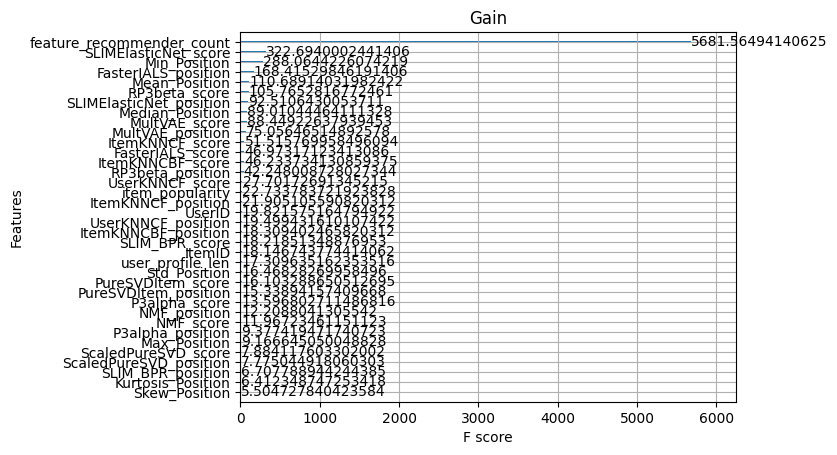

In [29]:
if config['tune_best_params']:
    plot_importance(recommender_instance.model, importance_type='gain', title='Gain')

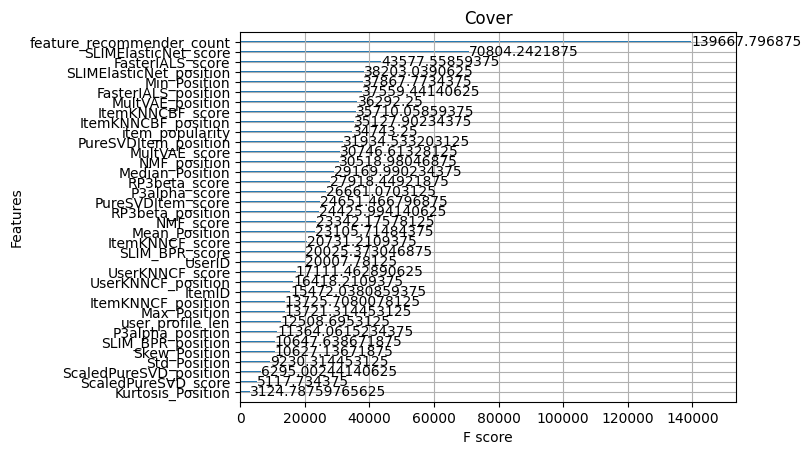

In [30]:
if config['tune_best_params']:
    plot_importance(recommender_instance.model, importance_type='cover', title='Cover')

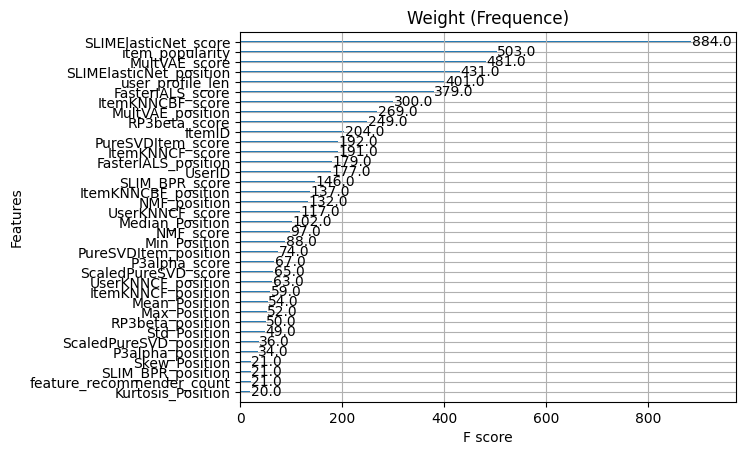

In [31]:
if config['tune_best_params']:
    plot_importance(recommender_instance.model, importance_type='weight', title='Weight (Frequence)')

# Submission

Create the recommendations for the submission.

In [32]:
if config['tune_best_params']:

    data_target_users_test = pd.read_csv('/kaggle/input/recommender-system-2024-challenge-polimi/data_target_users_test.csv')
    create_submission(data_target_users_test, recommender_instance, f'/kaggle/working/submission_{config["model"]}_{config["metric"]}.csv')

Submission file saved as /kaggle/working/submission_XGBoostNoCont_MAP.csv


# Save Version on GitHub 

Write or import a json file where best hyperparameters are saved. 

In [33]:
if config['tune_parameters']:
    with open(f'/kaggle/working/best_params_{config["model"]}_{config["metric"]}.json', 'w') as params_file:
        json.dump(optuna_study.best_params, params_file)
        
    if config['save_github']:
        upload_file(
            f'/kaggle/working/best_params_{config["model"]}_{config["metric"]}.json', 
            f'{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/best_params_{config["model"]}_{config["metric"]}.json', 
            f'{config["model"]}_{config["metric"]} tuning results (from kaggle notebook)',
            repo
        )
elif config['copy_prev_best_params']:
    shutil.copyfile(
        f'{K_PATH}/{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/'\
        f'best_params_{config["model"]}_{config["metric"]}.json', 
        f'/kaggle/working/best_params_{config["model"]}_{config["metric"]}.json'
    )

File 'TrainedModels/WithoutKFCV/XGBoost/XGBoostNoContRecommender/OptimizingMAP/best_params_XGBoostNoCont_MAP.json' updated successfully.


Save the history of the tuned model.

In [34]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'], 
        f'{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/history_{config["model"]}_{config["metric"]}.db',
        f'Tuning {config["model"]}_{config["metric"]} db updated results (from kaggle notebook)',
        repo
    )

File 'TrainedModels/WithoutKFCV/XGBoost/XGBoostNoContRecommender/OptimizingMAP/history_XGBoostNoCont_MAP.db' updated successfully.


Save the best trained model and its submission.

In [35]:
if config['save_github'] and config['tune_best_params']: 
    upload_file(
                f'/kaggle/working/submission_{config["model"]}_{config["metric"]}.csv', 
                f'{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/Submission/submission_{config["model"]}_{config["metric"]}.csv', 
                f'New {config["model"]}_{config["metric"]} submission (from kaggle notebook)',
                repo
            )

File 'TrainedModels/WithoutKFCV/XGBoost/XGBoostNoContRecommender/OptimizingMAP/Submission/submission_XGBoostNoCont_MAP.csv' updated successfully.
